In [58]:
# import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# import segmenteverygrain as seg
%matplotlib widget

In [59]:
# Define onpick
def onpick(event):
    # Only process individual left-clicks
    if event.mouseevent.dblclick is True or event.mouseevent.button != 1:
        return
    # Clear any previous highlight
    canvas = event.canvas
    canvas.restore_region(bg)
    # Update highlight
    new_xy = event.artist.get_xy()
    if new_xy is highlight.get_xy():
        new_xy = [(0,0)]
    highlight.set_xy(new_xy)
    # Draw new highlight on background
    ax.draw_artist(highlight)
    canvas.blit(fig.bbox)
    canvas.flush_events()

[]


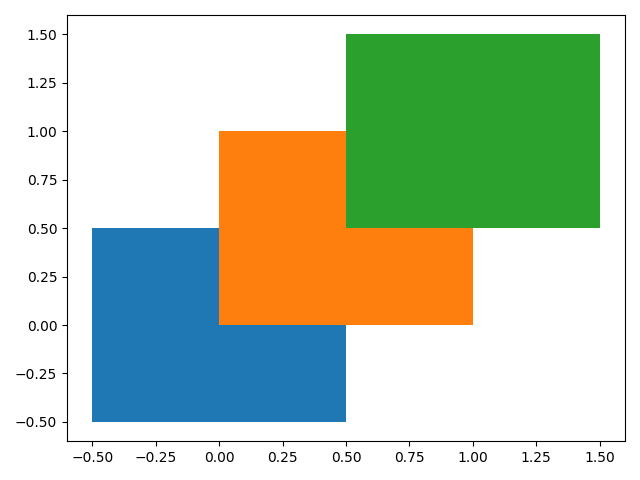

[[0. 1.]
 [1. 1.]
 [1. 0.]
 [0. 0.]
 [0. 1.]]
[[0.5 1.5]
 [1.5 1.5]
 [1.5 0.5]
 [0.5 0.5]
 [0.5 1.5]]
[[0.5 1.5]
 [1.5 1.5]
 [1.5 0.5]
 [0.5 0.5]
 [0.5 1.5]]
[[0.5 1.5]
 [1.5 1.5]
 [1.5 0.5]
 [0.5 0.5]
 [0.5 1.5]]
[[0.5 1.5]
 [1.5 1.5]
 [1.5 0.5]
 [0.5 0.5]
 [0.5 1.5]]
[[0.5 1.5]
 [1.5 1.5]
 [1.5 0.5]
 [0.5 0.5]
 [0.5 1.5]]
[[0. 1.]
 [1. 1.]
 [1. 0.]
 [0. 0.]
 [0. 1.]]
[[-0.5  0.5]
 [ 0.5  0.5]
 [ 0.5 -0.5]
 [-0.5 -0.5]
 [-0.5  0.5]]
[[0. 1.]
 [1. 1.]
 [1. 0.]
 [0. 0.]
 [0. 1.]]
[[0.5 1.5]
 [1.5 1.5]
 [1.5 0.5]
 [0.5 0.5]
 [0.5 1.5]]
[[0. 1.]
 [1. 1.]
 [1. 0.]
 [0. 0.]
 [0. 1.]]
[[-0.5  0.5]
 [ 0.5  0.5]
 [ 0.5 -0.5]
 [-0.5 -0.5]
 [-0.5  0.5]]
[[-0.5  0.5]
 [ 0.5  0.5]
 [ 0.5 -0.5]
 [-0.5 -0.5]
 [-0.5  0.5]]
[[-0.5  0.5]
 [ 0.5  0.5]
 [ 0.5 -0.5]
 [-0.5 -0.5]
 [-0.5  0.5]]
[[-0.5  0.5]
 [ 0.5  0.5]
 [ 0.5 -0.5]
 [-0.5 -0.5]
 [-0.5  0.5]]
[[-0.5  0.5]
 [ 0.5  0.5]
 [ 0.5 -0.5]
 [-0.5 -0.5]
 [-0.5  0.5]]
[[-0.5  0.5]
 [ 0.5  0.5]
 [ 0.5 -0.5]
 [-0.5 -0.5]
 [-0.5  0.5]]
[[-0.5  0.5]
 [ 0.

In [60]:
# TODO: Find grain from selection
# TODO: Delete grain on button press
# TODO: Merge grains on button press

# Create grain plot
fig, ax = plt.subplots()
grains = [(0, 0), (0.5, 0.5), (1, 1)]
for grain in grains:
    x, y = grain
    x = [x-0.5, x+0.5, x+0.5, x-0.5]
    y = [y+0.5, y+0.5, y-0.5, y-0.5]
    ax.fill(x, y, picker=True)

# Create highlighter
highlight, = ax.fill([], [], color='yellow', animated=True)

# Initialize plot background
plt.tight_layout()
plt.pause(0.1)
bg = fig.canvas.copy_from_bbox(fig.bbox)
fig.canvas.blit(fig.bbox)

# Attach onpick behavior
cid = fig.canvas.mpl_connect('pick_event', onpick)